# Simulación ATFE (Agitated Thin Film Evaporator) – Exportación a Excel/CSV/PNG

Este notebook incluye el parche de ebullición (banda de 1 K y reparto sensible/latente) y ahora exporta resultados a Excel/CSV y guarda las figuras en PNG.

Se generan curvas de: Temperatura, Viscosidad, Fracciones másicas, Coeficiente U, Potencia acumulada, y Caudal evaporado por segmento.


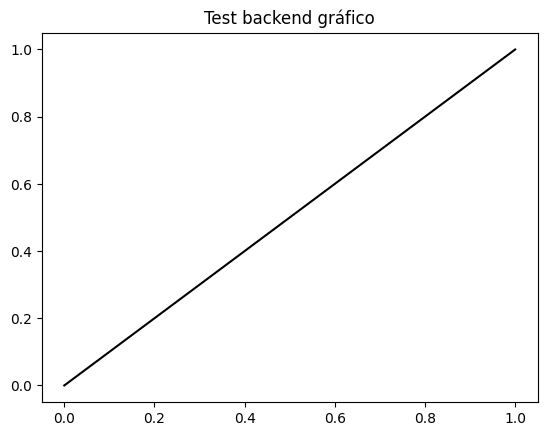

[INFO] thermo disponible – propiedades reales activadas.


In [6]:
# -*- coding: utf-8 -*-
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, traceback

def bar_to_Pa(bar): return bar * 1e5
def C_to_K(C): return C + 273.15
def K_to_C(K): return K - 273.15

# Test rápido del backend gráfico
plt.figure(); plt.plot([0,1],[0,1],'k-'); plt.title('Test backend gráfico'); plt.show()

# Intento de importación de thermo
try:
    from thermo import Mixture
    HAS_THERMO = True
    print('[INFO] thermo disponible – propiedades reales activadas.')
except Exception:
    HAS_THERMO = False
    print('[INFO] thermo NO disponible – modo simplificado para garantizar gráficas.')


In [7]:
def _safe_normalize(x):
    x = np.asarray(x, dtype=float)
    s = x.sum()
    if not np.isfinite(s) or s <= 0:
        return np.array([1.0, 0.0, 0.0])[:len(x)]
    return x / s

ATFE_PARAMS = {
    'L': 3.0,
    'D': 0.5,
    'RPM': 300.0,
    'film_thickness': 0.0008,
    'P_op_bar': 0.03,
    'T_wall_C': 190.0,
    'U_ref': 1500.0,
    'mu_ref': 0.0005,
    'exponent_n': 0.25,
    'N_steps': 50
}

FEED_DEFAULT = {
    'm_dot_kg_h': 500.0,
    'ws': [0.05, 0.45, 0.50],
    'T_feed_C': 60.0
}

def biodiesel_component(biodiesel_type='sunflower'):
    if biodiesel_type == 'sunflower':
        return 'methyl linoleate', 'Girasol (Linoleico)'
    elif biodiesel_type == 'palm':
        return 'methyl palmitate', 'Palma (Palmítico)'
    else:
        return 'methyl oleate', 'Genérico (Oleico)'


In [8]:
def simular_atfe(biodiesel_type='sunflower', feed=FEED_DEFAULT, params=ATFE_PARAMS, debug=False):
    try:
        L = params['L']; D = params['D']; N_steps = params['N_steps']
        Area_total = np.pi * D * L
        dA = Area_total / max(N_steps, 1)
        RPM = params['RPM']
        tip_speed = (RPM * np.pi * D) / 60.0
        film_th = max(params['film_thickness'], 1e-6)
        P_op_Pa = bar_to_Pa(params['P_op_bar'])
        T_wall_K = C_to_K(params['T_wall_C'])
        U_ref = params['U_ref']; mu_ref = params['mu_ref']; exponent_n = params['exponent_n']

        boil_band = 1.0
        latent_split_max = 0.85

        bio_comp, label = biodiesel_component(biodiesel_type)
        comps = ['methanol', 'dimethyl adipate', bio_comp]

        m_dot_feed = feed['m_dot_kg_h'] / 3600.0
        ws_feed = feed['ws']
        T_curr_K = C_to_K(feed['T_feed_C'])
        m_comps = [m_dot_feed * w for w in ws_feed]

        results = {'len': [], 'temp': [], 'visc': [], 'power_seg': [],
                   'w_meoh': [], 'w_dbe': [], 'w_bio': [], 'U': [],
                   'm_evap_seg': [], 'power_cum': [], 'm_liq': []}
        cumulative_power = 0.0

        for i in range(N_steps):
            m_liq_total = sum(m_comps)
            if not np.isfinite(m_liq_total) or m_liq_total <= 1e-12:
                if debug: print('[DEBUG] líquido agotado en i={}'.format(i))
                break
            ws_curr = _safe_normalize([m / m_liq_total for m in m_comps]).tolist()
            mu_liq = mu_ref
            Tb_meoh = C_to_K(30); Tb_dbe = C_to_K(150); Tb_bio = C_to_K(230)
            T_boil_K = ws_curr[0]*Tb_meoh + ws_curr[1]*Tb_dbe + ws_curr[2]*Tb_bio
            ws_vap = _safe_normalize([0.85, 0.15, 0.0])
            H_vap_mix = 6.0e5; Cp_liq = 2000.0
            if HAS_THERMO:
                try:
                    mix = Mixture(comps, ws=ws_curr, T=T_curr_K, P=P_op_Pa)
                    if getattr(mix, 'mul', None): mu_liq = mix.mul
                    try:
                        bp = mix.bubble_point_at_P(P_op_Pa)
                        if getattr(bp, 'T', None): T_boil_K = float(bp.T)
                    except Exception:
                        pass
                    try:
                        phase_eq = mix.flash(P=P_op_Pa, T=T_boil_K)
                        ys_v = np.asarray(phase_eq.y, dtype=float)
                        MWs = np.asarray(mix.MWs, dtype=float)
                        MW_avg = float((ys_v * MWs).sum())
                        if MW_avg > 0 and np.isfinite(MW_avg):
                            ws_vap = _safe_normalize((ys_v * MWs) / MW_avg)
                    except Exception:
                        pass
                    if getattr(mix, 'Hvapm', None) and getattr(mix, 'MW', None):
                        H_vap_mix = mix.Hvapm / (mix.MW / 1000.0)
                    if getattr(mix, 'Cplm', None) and getattr(mix, 'MW', None):
                        Cp_liq = mix.Cplm / (mix.MW / 1000.0)
                except Exception as e:
                    if debug: print('[DEBUG] fallo thermo en i={}:'.format(i), e)
            if not np.isfinite(mu_liq) or mu_liq <= 1e-12: mu_liq = mu_ref
            if not np.isfinite(Cp_liq) or Cp_liq < 100.0: Cp_liq = 2000.0
            if not np.isfinite(H_vap_mix) or H_vap_mix < 1e4: H_vap_mix = 6e5
            shear_rate = (tip_speed**2) / film_th
            P_seg = mu_liq * dA * shear_rate
            if not np.isfinite(P_seg): P_seg = 0.0
            cumulative_power += P_seg
            ratio = mu_ref / mu_liq if mu_liq > 1e-12 else 1.0
            U_local = float(np.clip(U_ref * (ratio ** exponent_n), 150.0, 2500.0))
            Q_watts = U_local * dA * (T_wall_K - T_curr_K)
            if not np.isfinite(Q_watts): Q_watts = 0.0
            m_evap = 0.0
            dT_to_boil = T_boil_K - T_curr_K
            if dT_to_boil > 1.0:
                dT = Q_watts / max(m_liq_total * Cp_liq, 1e-9)
                dT = float(np.clip(dT, -50.0, 50.0))
                T_curr_K = min(T_curr_K + dT, T_boil_K)
            elif dT_to_boil > 0.0:
                frac_latent = min(0.85, max(0.15, 1.0 - dT_to_boil/1.0))
                Q_lat = Q_watts * frac_latent
                Q_sens = Q_watts - Q_lat
                dT = Q_sens / max(m_liq_total * Cp_liq, 1e-9)
                dT = float(np.clip(dT, -5.0, 5.0))
                T_curr_K = min(T_curr_K + dT, T_boil_K)
                m_evap = Q_lat / max(H_vap_mix, 1.0)
                m_evap = float(np.clip(m_evap, 0.0, m_liq_total))
                ws_vap = _safe_normalize(ws_vap)
                for k in range(len(comps)):
                    m_comps[k] -= m_evap * ws_vap[k]
                    if m_comps[k] < 0.0 or not np.isfinite(m_comps[k]): m_comps[k] = 0.0
            else:
                m_evap = Q_watts / max(H_vap_mix, 1.0)
                m_evap = float(np.clip(m_evap, 0.0, m_liq_total))
                ws_vap = _safe_normalize(ws_vap)
                for k in range(len(comps)):
                    m_comps[k] -= m_evap * ws_vap[k]
                    if m_comps[k] < 0.0 or not np.isfinite(m_comps[k]): m_comps[k] = 0.0
            z = i * (L / max(N_steps, 1))
            results['len'].append(z)
            results['temp'].append(K_to_C(T_curr_K))
            results['visc'].append(mu_liq * 1000.0)
            results['power_seg'].append(P_seg)
            results['w_meoh'].append(ws_curr[0])
            results['w_dbe'].append(ws_curr[1])
            results['w_bio'].append(ws_curr[2])
            results['U'].append(U_local)
            results['m_evap_seg'].append(m_evap)
            results['power_cum'].append(cumulative_power)
            results['m_liq'].append(m_liq_total - m_evap)
            if debug and i % 10 == 0:
                print('[DEBUG] i={} | T={:.2f} °C | T_boil={:.2f} °C | dT={:.2f} K | Q={:.1f} W | m_evap={:.4f} kg/s'.format(
                      i, K_to_C(T_curr_K), K_to_C(T_boil_K), dT_to_boil, Q_watts, m_evap))

        return results, label, cumulative_power
    except Exception as e:
        print('[ERROR] en simular_atfe:', e)
        traceback.print_exc()
        return {'len':[], 'temp':[], 'visc':[], 'power_seg':[], 'w_meoh':[], 'w_dbe':[], 'w_bio':[], 'U':[], 'm_evap_seg':[], 'power_cum':[], 'm_liq':[]}, 'ERROR', 0.0


In [9]:
def resultados_a_dataframe(results):
    df = pd.DataFrame({
        'z_m': results.get('len', []),
        'T_liq_C': results.get('temp', []),
        'visc_cP': results.get('visc', []),
        'U_W_m2K': results.get('U', []),
        'w_meoh': results.get('w_meoh', []),
        'w_dbe': results.get('w_dbe', []),
        'w_bio': results.get('w_bio', []),
        'm_evap_seg_kg_s': results.get('m_evap_seg', []),
        'power_seg_W': results.get('power_seg', []),
        'power_cum_W': results.get('power_cum', []),
        'm_liq_kg_s': results.get('m_liq', [])
    })
    return df

def exportar_excel(res_list, xlsx_filename):
    # res_list: lista de tuplas (results, nombre_hoja)
    with pd.ExcelWriter(xlsx_filename, engine='openpyxl') as writer:
        for results, hoja in res_list:
            df = resultados_a_dataframe(results)
            df.to_excel(writer, sheet_name=hoja, index=False)
    print('[INFO] Excel guardado:', xlsx_filename)

def exportar_csv(results, csv_filename):
    df = resultados_a_dataframe(results)
    df.to_csv(csv_filename, index=False)
    print('[INFO] CSV guardado:', csv_filename)

def plot_resultados(results, label, potencia_total_kw=None, save_png_path=None):
    z = np.asarray(results['len'], dtype=float)
    fig = plt.figure(figsize=(14, 10))
    mstyle = {'lw':2, 'marker':'o', 'markersize':3, 'alpha':0.9}

    plt.subplot(3,2,1)
    plt.plot(z, results['temp'], 'r-', **mstyle)
    plt.title('Temperatura del líquido ({})'.format(label))
    plt.xlabel('Longitud axial, z (m)')
    plt.ylabel('T (°C)')
    plt.grid(True)

    plt.subplot(3,2,2)
    plt.plot(z, results['visc'], 'b-', **mstyle)
    plt.title('Viscosidad del líquido')
    plt.xlabel('Longitud axial, z (m)')
    plt.ylabel('μ (cP)')
    plt.grid(True)

    plt.subplot(3,2,3)
    plt.plot(z, results['w_meoh'], label='MeOH', **mstyle)
    plt.plot(z, results['w_dbe'],  label='DBE',  **mstyle)
    plt.plot(z, results['w_bio'],  label='Biodiésel', **mstyle)
    plt.title('Fracciones másicas en líquido')
    plt.xlabel('Longitud axial, z (m)')
    plt.ylabel('w (-)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3,2,4)
    plt.plot(z, results['U'], 'g-', **mstyle)
    plt.title('Coeficiente global U')
    plt.xlabel('Longitud axial, z (m)')
    plt.ylabel('U (W/m²·K)')
    plt.grid(True)

    plt.subplot(3,2,5)
    power_cum_kw = np.asarray(results['power_cum'], dtype=float) / 1000.0
    plt.plot(z, power_cum_kw, 'm-', **mstyle)
    plt.title('Potencia acumulada del rotor')
    plt.xlabel('Longitud axial, z (m)')
    plt.ylabel('Potencia acumulada (kW)')
    plt.grid(True)

    plt.subplot(3,2,6)
    m_evap_seg = np.asarray(results['m_evap_seg'], dtype=float)
    width = (z[1]-z[0] if len(z)>1 else 0.05)
    plt.bar(z, m_evap_seg, width=width, color='#1f77b4', alpha=0.7, edgecolor='k', label='m_evap,seg (kg/s)')
    plt.plot(z, m_evap_seg, 'k-', lw=1.2, alpha=0.8, label='traza')
    max_val = float(np.nanmax(m_evap_seg)) if m_evap_seg.size else 0.0
    if not np.isfinite(max_val) or max_val <= 0.0: max_val = 1e-6
    plt.ylim(bottom=0.0, top=max_val*1.15)
    plt.title('Caudal evaporado por segmento')
    plt.xlabel('Longitud axial, z (m)')
    plt.ylabel('m_evap,seg (kg/s)')
    plt.grid(True, axis='y')
    plt.legend()

    plt.tight_layout()
    if potencia_total_kw is not None:
        plt.suptitle('ATFE – {} | Potencia total rotor: {:.3f} kW'.format(label, potencia_total_kw), y=1.02, fontsize=13)
    if save_png_path:
        plt.savefig(save_png_path, dpi=200, bbox_inches='tight')
        print('[INFO] Figura guardada:', save_png_path)
    plt.show()

def plot_comparacion(res_sun, res_palm, label_sun, label_palm, save_png_path=None):
    z_s = np.asarray(res_sun['len'], dtype=float)
    z_p = np.asarray(res_palm['len'], dtype=float)
    plt.figure(figsize=(16, 12))
    mstyle = {'lw':2, 'markersize':3, 'alpha':0.95}

    plt.subplot(3,2,1)
    plt.plot(z_s, res_sun['temp'], 'r-o', label='T ({})'.format(label_sun), **mstyle)
    plt.plot(z_p, res_palm['temp'], 'r--s', label='T ({})'.format(label_palm), **mstyle)
    plt.title('Comparación: Temperatura del líquido')
    plt.xlabel('z (m)'); plt.ylabel('T (°C)'); plt.grid(True); plt.legend()

    plt.subplot(3,2,2)
    plt.plot(z_s, res_sun['visc'], 'b-o', label='μ ({})'.format(label_sun), **mstyle)
    plt.plot(z_p, res_palm['visc'], 'b--s', label='μ ({})'.format(label_palm), **mstyle)
    plt.title('Comparación: Viscosidad del líquido')
    plt.xlabel('z (m)'); plt.ylabel('μ (cP)'); plt.grid(True); plt.legend()

    plt.subplot(3,2,3)
    plt.plot(z_s, res_sun['U'], 'g-o', label='U ({})'.format(label_sun), **mstyle)
    plt.plot(z_p, res_palm['U'], 'g--s', label='U ({})'.format(label_palm), **mstyle)
    plt.title('Comparación: Coeficiente global U')
    plt.xlabel('z (m)'); plt.ylabel('U (W/m²·K)'); plt.grid(True); plt.legend()

    plt.subplot(3,2,4)
    plt.plot(z_s, res_sun['w_meoh'], 'm-o', label='MeOH ({})'.format(label_sun), **mstyle)
    plt.plot(z_p, res_palm['w_meoh'], 'm--s', label='MeOH ({})'.format(label_palm), **mstyle)
    plt.title('Comparación: Fracción MeOH en líquido')
    plt.xlabel('z (m)'); plt.ylabel('w (-)'); plt.grid(True); plt.legend()

    plt.subplot(3,2,5)
    plt.plot(z_s, np.asarray(res_sun['power_cum'])/1000.0, 'c-o', label='Power ({})'.format(label_sun), **mstyle)
    plt.plot(z_p, np.asarray(res_palm['power_cum'])/1000.0, 'c--s', label='Power ({})'.format(label_palm), **mstyle)
    plt.title('Comparación: Potencia acumulada del rotor')
    plt.xlabel('z (m)'); plt.ylabel('kW'); plt.grid(True); plt.legend()

    plt.subplot(3,2,6)
    width_s = (z_s[1]-z_s[0] if len(z_s)>1 else 0.05)
    width_p = (z_p[1]-z_p[0] if len(z_p)>1 else 0.05)
    plt.bar(z_s - width_s/2, res_sun['m_evap_seg'], width=width_s, color='#1f77b4', alpha=0.6, label='m_evap ({})'.format(label_sun))
    plt.bar(z_p + width_p/2, res_palm['m_evap_seg'], width=width_p, color='#ff7f0e', alpha=0.6, label='m_evap ({})'.format(label_palm))
    plt.title('Comparación: Caudal evaporado por segmento')
    plt.xlabel('z (m)'); plt.ylabel('kg/s'); plt.grid(True, axis='y'); plt.legend()

    plt.tight_layout()
    if save_png_path:
        plt.savefig(save_png_path, dpi=200, bbox_inches='tight')
        print('[INFO] Figura comparativa guardada:', save_png_path)
    plt.show()


In [10]:
try:
    res_sun, label_sun, pow_sun_W = simular_atfe('sunflower', feed=FEED_DEFAULT, params=ATFE_PARAMS, debug=False)
    res_palm, label_palm, pow_palm_W = simular_atfe('palm', feed=FEED_DEFAULT, params=ATFE_PARAMS, debug=False)
    print('Potencia Total Rotor ({}): {:.3f} kW'.format(label_sun, pow_sun_W/1000.0))
    print('Potencia Total Rotor ({}): {:.3f} kW'.format(label_palm, pow_palm_W/1000.0))

    exportar_excel([(res_sun, 'Girasol'), (res_palm, 'Palma')], 'ATFE_resultados_base.xlsx')
    exportar_csv(res_sun, 'ATFE_base_girasol.csv')
    exportar_csv(res_palm, 'ATFE_base_palma.csv')

    plot_resultados(res_sun,  label_sun,  potencia_total_kw=pow_sun_W/1000.0, save_png_path='ATFE_base_girasol.png')
    plot_resultados(res_palm, label_palm, potencia_total_kw=pow_palm_W/1000.0, save_png_path='ATFE_base_palma.png')
except Exception as e:
    print('[ERROR] en ejecución base:', e)
    traceback.print_exc()


Potencia Total Rotor (Girasol (Linoleico)): 0.217 kW
Potencia Total Rotor (Palma (Palmítico)): 0.141 kW
[ERROR] en ejecución base: No module named 'openpyxl'


Traceback (most recent call last):
  File "/var/folders/nh/vbg7pt9915z20h5bqjk7f5xc0000gn/T/ipykernel_22462/2759514914.py", line 7, in <module>
    exportar_excel([(res_sun, 'Girasol'), (res_palm, 'Palma')], 'ATFE_resultados_base.xlsx')
    ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/nh/vbg7pt9915z20h5bqjk7f5xc0000gn/T/ipykernel_22462/3298723483.py", line 19, in exportar_excel
    with pd.ExcelWriter(xlsx_filename, engine='openpyxl') as writer:
         ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/anxo/Documents/libro-agrosolvents/.venv/lib/python3.13/site-packages/pandas/io/excel/_openpyxl.py", line 57, in __init__
    from openpyxl.workbook import Workbook
ModuleNotFoundError: No module named 'openpyxl'


---
*Notebook generado automáticamente el 2026-01-01 21:35:27.*